# Demo - Conditional Gaussianization Flow (Regression)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [90]:
from distrax._src.distributions.categorical import Categorical
from distrax._src.distributions.mixture_same_family import MixtureSameFamily
from distrax._src.distributions.bernoulli import Bernoulli
from distrax._src.distributions.uniform import Uniform
from distrax._src.distributions.normal import Normal
from tensorflow_probability.substrates import jax as tfp
import uncertainty_toolbox.viz as uviz
import uncertainty_toolbox.metrics as umetric
import uncertainty_toolbox.data as udata

tfd = tfp.distributions
logits = jnp.array([0.33, 0.33, 0.33])
probs = jax.nn.softmax(logits, axis=-1)
x_cat_dist = Categorical(probs=probs)
norm_dist = Normal(loc=[-4.0, 0.0, 4.0], scale=[0.4, 0.6, 0.4])
mix_dist = MixtureSameFamily(x_cat_dist, norm_dist)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [230]:
def synthetic_mixture(n_samples: int = 1_000, X=None):
    if X is None:
        logits = jnp.array([1.0, 1.0, 1.0])
        probs = jax.nn.softmax(logits, axis=-1)
        x_cat_dist = Categorical(probs=probs)
        norm_dist = Normal(loc=[-4.0, 0.0, 4.0], scale=[0.7, 0.6, 0.7])
        mix_dist = MixtureSameFamily(x_cat_dist, norm_dist)
        X_samples = mix_dist.sample(seed=123, sample_shape=(n_samples,))
    else:
        X_samples = X
    loc = np.sin(X_samples.ravel())
    scale = np.exp(np.cos(X_samples.ravel()))
    Y = np.random.normal(loc, scale)[:, None]
    return X_samples[:, None], Y


def synthetic_bowtie(n_samples: int = 1_000, X=None):
    if X is None:
        X = jnp.linspace(0, 4 * jnp.pi, n_samples)[:, None]
    loc = np.sin(X.ravel())
    scale = np.exp(np.cos(X.ravel()))
    Y = np.random.normal(loc, scale)[:, None]
    return X, Y


def noisy_near_square_wave(n_samples, y_noise=0.05, seed=123, x_noise=0.3):
    rng = np.random.RandomState(seed)
    X_mu = np.linspace(-10, 10, n_samples)
    X = X_mu + x_noise * rng.randn(*X_mu.shape)

    # sort the values
    idx = np.argsort(X)
    X_mu = X_mu[idx]
    X = X[idx]

    f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + 0.5 * x))
    rng = np.random.RandomState(seed + 1)
    Y = f(X_mu) + y_noise * rng.randn(*X_mu.shape)
    return X_mu[:, None], X[:, None], Y[:, None]


def near_square_wave(n_samples, noise=0.3, seed=123):
    X = np.linspace(-10, 10, n_samples)
    f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + 0.5 * x))
    rng = np.random.RandomState(seed)
    Y = f(X) + noise * rng.randn(X.shape[0])
    return X, Y


def synthetic_heteroscedastic(
    n_samples: int = 1_000, noise: float = 0.3, dataset: str = "bowtie", seed: int = 123
):
    # Load an example dataset of 100 predictions, uncertainties, and observations
    if dataset == "bowtie":
        *_, Y, X = udata.synthetic_bowtie(n_samples)
    elif dataset == "hetero":
        *_, Y, X = udata.synthetic_heteroscedastic(n_samples)
    elif dataset == "mixture":
        *_, Y, X = udata.synthetic_mixture(n_samples)
    elif dataset == "sine":
        *_, Y, X = udata.synthetic_sine_heteroscedastic(n_samples)
    elif dataset == "nearsquare":
        X = np.linspace(-10, 10, n_samples)
        f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + 0.5 * x))
        rng = np.random.RandomState(seed)
        Y = f(X) + noise * rng.randn(X.shape[0])
    else:
        raise ValueError(f"{dataset} not available")

    return X[:, None], Y[:, None]

In [281]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn import datasets
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_samples: int,
    batch_size: int,
    seed: int,
    n_features: int = 2,
    noise: float = 0.05,
    dataset: str = "nearsquare",
) -> Iterator[Batch]:
    # make random normally distributed data
    rng = np.random.RandomState(seed)
    #     _, X, Y = noisy_near_square_wave(n_samples, x_noise=0.5, y_noise=0.05, seed=seed)
    X, Y = synthetic_mixture(n_samples,)
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [282]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 1_000
n_train = 1_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)

# demo batch
init_X, init_Y = next(init_ds)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [283]:
init_Y.shape, init_X.shape

((1000, 1), (1000, 1))

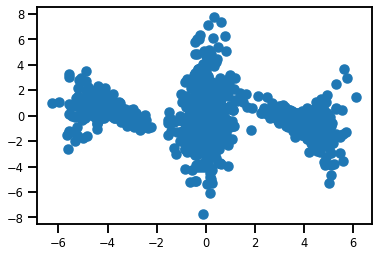

In [284]:
fig, ax = plt.subplots()

ax.scatter(init_X, init_Y)
plt.show()

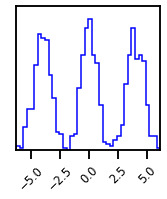

In [285]:
# plot data
fig = corner.corner(init_X, color="blue", hist_bin_factor=2)

## DataLoader

In [286]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch) -> Array:
    inputs, labels = batch

    # select image from tfds
    inputs = inputs.astype(jnp.float32)
    labels = labels.astype(jnp.float32)

    # make 1D
    #     labels = jnp.expand_dims(labels, axis=-1)

    return inputs, labels

## Model

In [287]:
from rbig_jax.models.gaussflow import init_default_gf_model

# initialization data
n_init_samples = 1_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)
# demo batch
init_ds = next(init_ds)
X_init, Y_init = prepare_data(init_ds)
X_init, Y_init = np.array(X_init), np.array(Y_init)


# marginal uniformization
mixture = "gaussian"
n_components = 5
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "gaussian"

# rotation transformation
n_reflections = 2
init_rotation = "random"

# nn params
n_blocks = 3

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [288]:
X_init.shape, Y_init.shape

((1000, 1), (1000, 1))

In [289]:
# init model
gf_model = init_default_gf_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 3 | Layer 8: 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


### Plot Initial Layers

In [290]:
%%time

# X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

gf_model.score(X_init)

CPU times: user 369 ms, sys: 35.7 ms, total: 404 ms
Wall time: 355 ms


DeviceArray(2.1543953, dtype=float32)

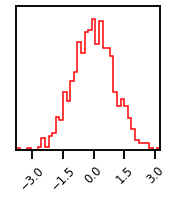

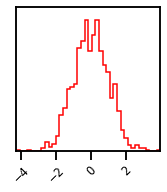

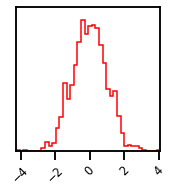

In [291]:
X_g = X_init.copy()

for ibijector in gf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

### Conditional Model

In [292]:
from distrax._src.distributions.log_stddev_normal import LogStddevNormal
from typing import Sequence, Callable, Tuple
import flax
from flax import linen as nn
from flax import struct


class ExplicitMLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        # we automatically know what to do with lists, dicts of submodules
        self.layers = [nn.Dense(feat) for feat in self.features]
        # for single submodules, we would just write:
        # self.layer1 = nn.Dense(self, feat1)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x


const = jnp.log(jnp.expm1(1.0))


@struct.dataclass
class ConditionalModel:
    params: dict
    model: Callable = struct.field(pytree_node=False)

    def forward(self, inputs) -> Tuple[Array, Array]:
        # forward pass for params
        outputs = self.model.apply(self.params, inputs)
        # split params
        split = outputs.shape[1] // 2

        # compute means and log stds
        means = outputs[..., :split]
        log_stds = outputs[..., split:]

        dist = LogStddevNormal(loc=means, log_scale=log_stds)

        return dist

In [293]:
from distrax._src.distributions.normal import Normal

# create model
input_features = X_init.shape[1]
# model = nn.Dense(features=input_features * 2)
model = ExplicitMLP(features=[50, 30, 10, 2])
# create dummy variable
rng, model_rng = jax.random.split(KEY, 2)
params = model.init(model_rng, X_init)

In [294]:
# initialize conditional model
cond_model = ConditionalModel(params=params, model=model)

# forward pass
y_dist = cond_model.forward(X_init)
y_dist.mean().shape, y_dist.stddev().shape

((1000, 1), (1000, 1))

In [295]:
from rbig_jax.transforms.base import Bijector, BijectorChain
from typing import Iterable
from chex import dataclass
from distrax._src.distributions.distribution import Distribution
import abc


@struct.dataclass
class GFRegressor(BijectorChain):
    bijectors: Iterable[Bijector]
    base_dist: Distribution = struct.field(pytree_node=False)
    encoder: Callable
    trade_off: float = struct.field(pytree_node=False)

    def predict(self, inputs: Array):
        # forward through latent
        z = self.forward(inputs)

        # push through encoder
        return self.encoder.forward(z)

    def score_gen(self, inputs):

        # forward propagation
        z, log_det = self.forward_and_log_det(inputs)

        # calculate log probability
        latent_prob = self.base_dist.log_prob(z).sum(axis=1) + log_det.sum(axis=1)

        return latent_prob

    def score(self, inputs, outputs):

        # forward propagation
        z, log_det = self.forward_and_log_det(inputs)

        y_dist = self.encoder.forward(z)

        # latent distribution
        regress_loss = y_dist.log_prob(outputs).sum(axis=1)

        regress_loss = -jnp.mean(regress_loss, axis=0)

        # calculate log probability
        latent_prob = self.base_dist.log_prob(z).sum(axis=1) + log_det.sum(axis=1)

        gen_loss = -jnp.mean(latent_prob)

        return regress_loss + self.trade_off * gen_loss

    def sample(self, seed: int, n_samples: int):
        raise NotImplementedError()


#         # generate Gaussian samples
#         X_g_samples = self.base_dist.sample(seed=seed, sample_shape=n_samples)
#         # # inverse transformation
#         return self.inverse(X_g_samples)

In [296]:
from distrax._src.distributions.normal import Normal

cgf_model = GFRegressor(
    bijectors=gf_model.bijectors,
    base_dist=Normal(0.0, 1.0),
    encoder=cond_model,
    trade_off=1.0,
)
cgf_model.trade_off

1.0

#### Training

In [297]:
from chex import dataclass


def loss_fn(model, batch: Batch) -> Array:

    inputs, outputs = prepare_data(batch)

    return model.score(inputs, outputs)


@jax.jit
def eval_fn(model, batch: Batch) -> Array:

    inputs, outputs = prepare_data(batch)

    return model.score(inputs, outputs)

In [298]:
init_ds = load_dataset(n_init_samples, n_init_samples, 123)

nll_loss = loss_fn(cgf_model, next(init_ds))
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")


nll_loss = eval_fn(cgf_model, next(init_ds))
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


Initial NLL Loss (Train): 4.7660
Initial NLL Loss (Train): 4.7661


### Optimizer

In [299]:
from rbig_jax.training.parametric import init_optimizer

# optimizer params

eval_frequency = 50
learning_rate = 1e-3

n_epochs = 5_000
# initialize optimizer
optimizer = init_optimizer(
    "adam",
    n_epochs=n_epochs,
    lr=learning_rate,
    cosine_decay_steps=n_epochs,
    warmup=None,
    gradient_clip=15.0,
    alpha=1e-2,
)
# intialize optimizer state
opt_state = optimizer.init(cgf_model)

### Train Step

In [300]:
from typing import Tuple, Any
import optax

OptState = Any


@jax.jit
def update(
    params: dataclass, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Train Loop

In [301]:
train_ds = load_dataset(n_train, 256, 123)
valid_ds = load_dataset(2_000, 1_000, 123 + 100)


metrics = {
    "train_step": list(),
    "train_loss": list(),
    "valid_step": list(),
    "valid_loss": list(),
}


eval_loss = 0.0

In [302]:
# %%wandb

import tqdm


with tqdm.trange(n_epochs) as pbar:
    for step in pbar:
        cgf_model, opt_state, loss = update(cgf_model, opt_state, next(train_ds))

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        #         wandb.log({"train_loss": float(loss), "training_step": step})
        metrics["train_step"].append(step)
        metrics["train_loss"].append(loss)

        if step % eval_frequency == 0:
            eval_loss = eval_fn(cgf_model, next(valid_ds))

            pbar.set_description(
                f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )
            #             wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            metrics["valid_step"].append(step)
            metrics["valid_loss"].append(eval_loss)

Train Loss: 3.6030 | Valid Loss: 3.4466: 100%|██████████| 5000/5000 [00:26<00:00, 186.86it/s]


### Results

#### Losses

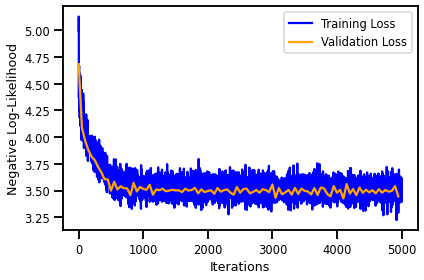

In [303]:
fig, ax = plt.subplots()
ax.plot(
    metrics["train_step"], metrics["train_loss"], label="Training Loss", color="blue"
)
ax.plot(
    metrics["valid_step"],
    metrics["valid_loss"],
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

### Log Probability

#### Plot: Original Density

In [267]:
# X_plot, Y_plot = near_square_wave(10_000, 0.3)
_, X_plot, Y_plot = noisy_near_square_wave(10_000, x_noise=0.5, y_noise=0.05, seed=42)

In [304]:
n_plot_samples = 10_000
rng = np.random.RandomState(42)
X_plot = np.linspace(init_X.min(), init_X.max(), n_plot_samples)[:, None]
_, Y_plot = synthetic_mixture(None, X_plot)

In [305]:
y_dist = cgf_model.predict(X_plot)

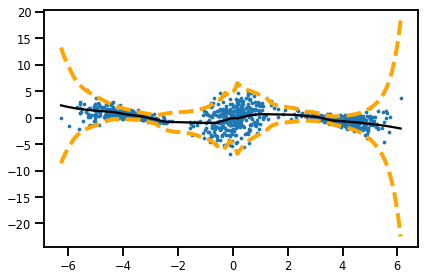

In [306]:
fig, ax = plt.subplots()
plt.plot(X_plot, y_dist.mean(), color="black")
plt.plot(
    X_plot,
    y_dist.mean() + 1.96 * y_dist.stddev(),
    color="orange",
    linestyle="--",
    linewidth=4,
)
plt.plot(
    X_plot,
    y_dist.mean() - 1.96 * y_dist.stddev(),
    color="orange",
    linestyle="--",
    linewidth=4,
)
ax.scatter(X_init, Y_init, s=5)
plt.tight_layout()
plt.show()

In [307]:
import uncertainty_toolbox.viz as uviz
import uncertainty_toolbox.metrics as umetric

In [272]:
# Compute all uncertainty metrics
metrics = umetric.get_all_metrics(
    y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel(),
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


  0%|          | 0/10 [00:00<?, ?it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


  0%|          | 0/10 [00:00<?, ?it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.148
  RMSE          0.233
  MDAE          0.076
  MARPD         33.453
  R2            0.924
  Correlation   0.961
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.012
  Mean-absolute Calibration Error       0.008
  Miscalibration Area                   0.009
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.019
     Group Size: 0.56 -- Calibration Error: 0.011
     Group Size: 1.00 -- Calibration Error: 0.008
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.024
     Group Size: 0.56 -- Calibration Error: 0.015
     Group Size: 1.00 -- Calibration Error: 0.012
===============

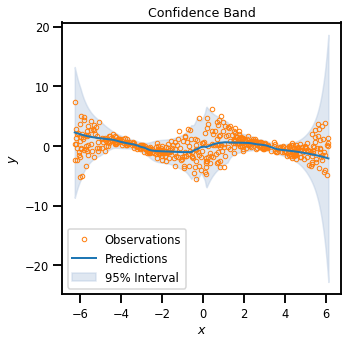

In [308]:
uviz.plot_xy(
    y_dist.mean().ravel(),
    y_dist.stddev().ravel(),
    Y_plot.ravel(),
    X_plot.ravel(),
    n_subset=500,
)

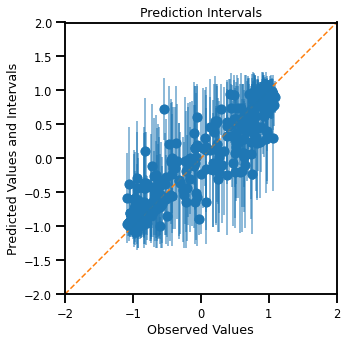

In [274]:
uviz.plot_intervals(
    y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel(), n_subset=500,
)

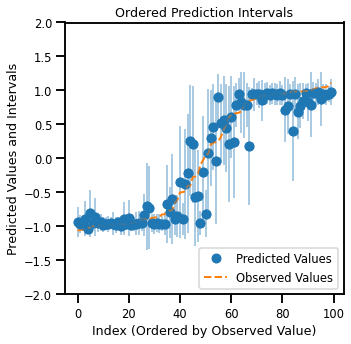

In [275]:
uviz.plot_intervals_ordered(
    y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel(), n_subset=100
)

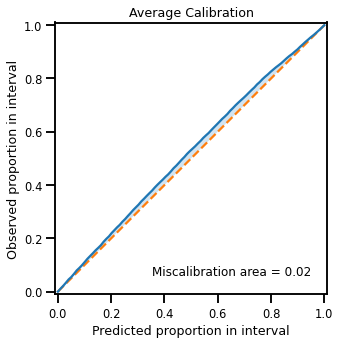

In [309]:
uviz.plot_calibration(y_dist.mean().ravel(), y_dist.stddev().ravel(), Y_plot.ravel())

In [310]:
X_log_prob = cgf_model.score_gen(X_plot)

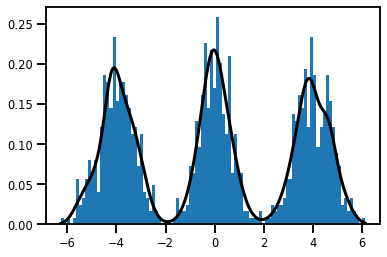

In [311]:
fig, ax = plt.subplots()
ax.hist(init_X, bins=100, density=True)
ax.plot(X_plot, np.exp(X_log_prob), linewidth=3, color="black")
plt.show()

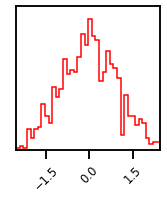

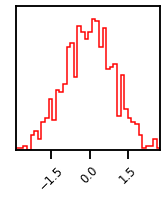

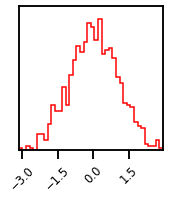

In [280]:
X_g = X_init.copy()

for ibijector in cgf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

In [25]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

## Saving/Loading Model

#### Save Model

In [34]:
import joblib

joblib.dump(cgf_model, "gf_model.pickle")

['gf_model.pickle']

#### Load Model

In [35]:
rbig_model_loaded = joblib.load("gf_model.pickle")